# Plotting Strait Transports in ACCESS-OM3

Based on https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/strait_transports/strait_transports.ipynb

In [1]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime

In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [3]:
om3exptname = "MC_25km_jra_ryf-1.0-beta"

datastore = intake.open_esm_datastore(
    f"/g/data/ol01/access-om3-output/access-om3-025/{om3exptname}/experiment_datastore.json",
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [4]:
# Strait locations: [minlon, maxlon, minlat, maxlat]
# Add as many as you like, but they must be zonal or meridional
straits = dict()
straits['25km'] = {
            'Drake Passage':       [-69.9,   -69.9,  -71.6, -51.0],
            'Lombok Strait':       [-244.8, -243.5,  -8.5, -8.5],
            'Ombai Strait':        [-235.0, -235.0,  -9.21, -8.3],
            'Timor Strait':        [-233,     -233, -13.86, -8.5],
            'Bering Strait':       [-172,     -167,   65.8,  65.8],
            'Denmark Strait':      [-42,       -22,   65.8,  65.8],
            'East Taiwan Channel': [-238.3,   -236,   24.4,  24.4],  # WOCE PCM-1 array between Taiwan and Iriomote, JohnsLeeZhangZantoppLiuYang2001a http://dx.doi.org/10.1175/1520-0485(2001)031<1031:TKEOTM>2.0.CO;2
            'Florida Current':     [-81,     -78.8,   26.7,  26.7],  # MeinenBaringerGarcia2010a http://dx.doi.org/10.1016/j.dsr.2010.04.001
            'Bosphorus':           [28.5, 29.2, 41.15, 41.15],
            'Gibraltar':           [-5.5, -5.5, 35.5, 36.5, ],
}

In [5]:
# from https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/strait_transports/strait_transports.ipynb
# Strait locations: [minlon, maxlon, minlat, maxlat]
# Add as many as you like, but they must be zonal or meridional
om2straits = dict()
om2straits['01deg'] = {
            'Drake Passage': [-69.9, -69.9, -71.6, -51.0],
            'Lombok Strait': [-244.3, -243.8, -8.37, -8.37],
            'Ombai Strait':  [-234.9, -234.9, -8.86, -8.27],
            'Timor Strait':  [-232.6, -232.6, -13.96, -8.37],
            'Bering Strait': [-172, -167, 65.8, 65.8],
            'Denmark Strait':[-42, -22, 65.8, 65.8],
            'East Taiwan Channel':[121.7-360, 124-360, 24.4, 24.4],  # WOCE PCM-1 array between Taiwan and Iriomote (JohnsLeeZhangZantoppLiuYang2001a)
            'Florida Current':[-81, -78.8, 26.7, 26.7],  # MeinenBaringerGarcia2010a
            }
om2straits['025deg'] = {
            'Drake Passage': [-69.9, -69.9, -71.6, -51.0],
            'Lombok Strait': [-244.5, -243.5, -8.22, -8.22],
            'Ombai Strait':  [-235.5, -235.5, -9.21, -8.47],
            'Timor Strait':  [-233, -233, -13.86, -8.71],
            'Bering Strait':       [-172,     -167,   65.8,  65.8],
            'Denmark Strait':      [-42,       -22,   65.8,  65.8],
            'East Taiwan Channel':[121.7-360, 124-360, 24.4, 24.4],  # WOCE PCM-1 array between Taiwan and Iriomote (JohnsLeeZhangZantoppLiuYang2001a)
            'Florida Current':[-81, -78.8, 26.7, 26.7],  # MeinenBaringerGarcia2010a
            'Bosphorus':           [28.5, 29.5, 41.15, 41.15],
            'Gibraltar':           [-5.5, -5.5, 35.5, 36.5, ],
            }
om2straits['1deg'] = {
            'Drake Passage': [-69.9, -69.9, -71.6, -51.0],
            'Lombok Strait': [-245, -242, -8.33, -8.33],
            'Ombai Strait':  [-237, -237, -10.33, -8.33],
            'Timor Strait':  [-233, -233, -13.9, -9],
            'East Taiwan Channel':[121.7-360, 125-360, 24.4, 24.4],  # xmax extended by 1deg as in TsengLinChenThompsonBentsenBoningBozecCassouChassignet2016a
            'Florida Current':[-81, -77.8, 26.7, 26.7], # xmax extended  # MeinenBaringerGarcia2010a
            }

In [6]:
obs = {  # observed transport (Sv)
# TODO: include error bars/stdev
# Also see table 3 in GutjahrETAL2019a http://dx.doi.org/10.5194/gmd-12-3241-2019
# table 1 in YangCessi2024a http://dx.doi.org/10.1029/2024JC021463
            'Drake Passage': {'Donohue et al. (2016)': 173},  # DonohueTraceyWattsChidichimoChereskin2016a http://dx.doi.org/10.1002/2016GL070319
            'Lombok Strait': {'Sprintall et al. (2009)': -2.6},  # INSTANT, SprintallWijffelsMolcardJaya2009a http://dx.doi.org/10.1029/2008JC005257
            'Ombai Strait':  {'Sprintall et al. (2009)': -4.9},  # INSTANT, SprintallWijffelsMolcardJaya2009a http://dx.doi.org/10.1029/2008JC005257
            'Timor Strait':  {'Sprintall et al. (2009)': -7.5},  # INSTANT, SprintallWijffelsMolcardJaya2009a http://dx.doi.org/10.1029/2008JC005257
            'Bering Strait': {'Woodgate (2018)': 1},  # Woodgate2018a http://dx.doi.org/10.1016/j.pocean.2017.12.007
            # 'Denmark Strait':  {},
            'East Taiwan Channel': {'Johns et al. (2001)': 21.5},  # WOCE PCM-1 array between Taiwan and Iriomote, JohnsLeeZhangZantoppLiuYang2001a http://dx.doi.org/10.1175/1520-0485(2001)031<1031:TKEOTM>2.0.CO;2
            'Florida Current': {'Meinen et al. (2010)': 32.1},  # MeinenBaringerGarcia2010a http://dx.doi.org/10.1016/j.dsr.2010.04.001
            # 'Bosphorus':  {},
            # 'Gibraltar': {},
}

## Load OM3 data and plot transects

In [7]:
umo_2d = datastore.search(variable="umo_2d").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

In [8]:
vmo_2d = datastore.search(variable="vmo_2d").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

In [9]:
uo = datastore.search(variable="uo").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

In [10]:
vo = datastore.search(variable="vo").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

In [11]:
# Restrict time range of OM2 data to match OM3
timeslice = slice(umo_2d.time.values[0], umo_2d.time.values[-1])
timeslice

slice(cftime.DatetimeNoLeap(1900, 1, 16, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1951, 12, 16, 12, 0, 0, 0, has_year_zero=True), None)

Drake Passage
Lombok Strait
Ombai Strait
Timor Strait
Bering Strait
Denmark Strait
East Taiwan Channel
Florida Current
Bosphorus
Gibraltar


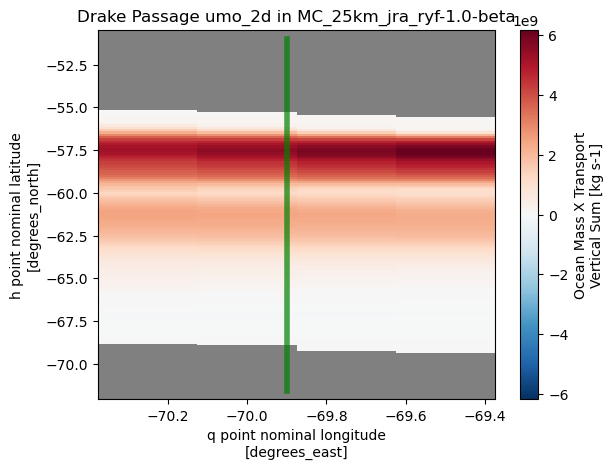

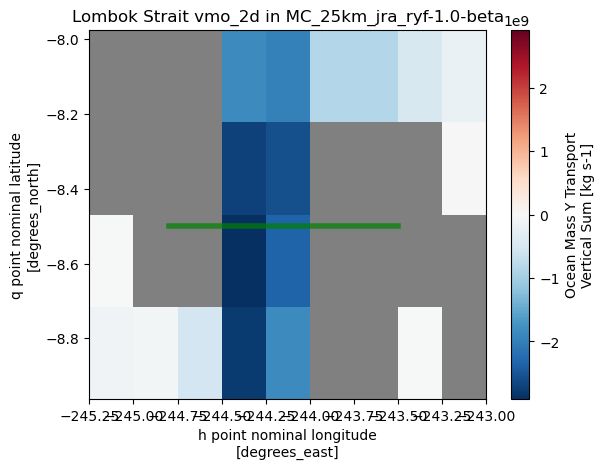

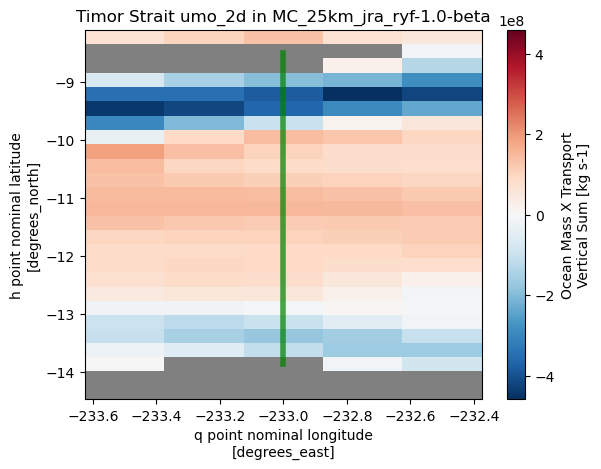

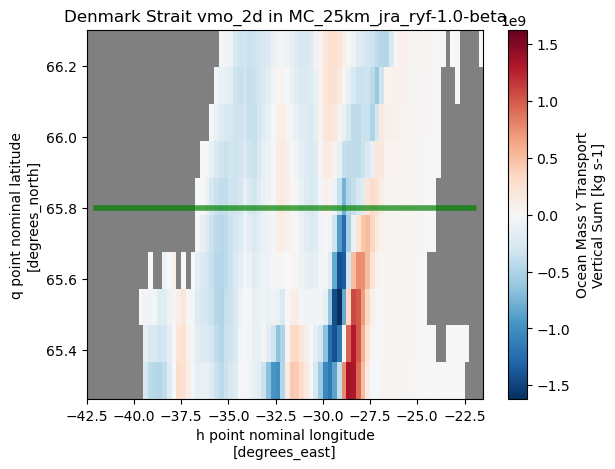

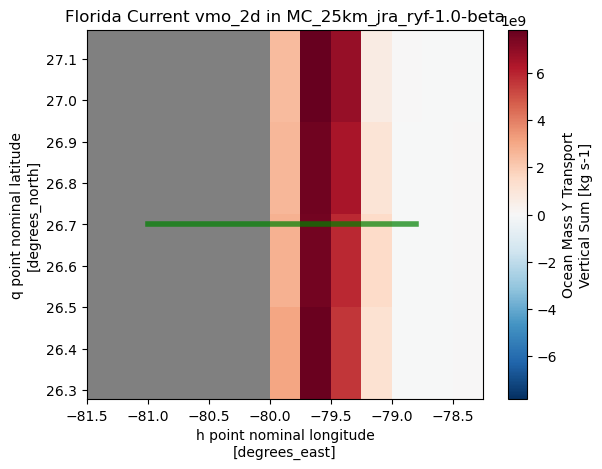

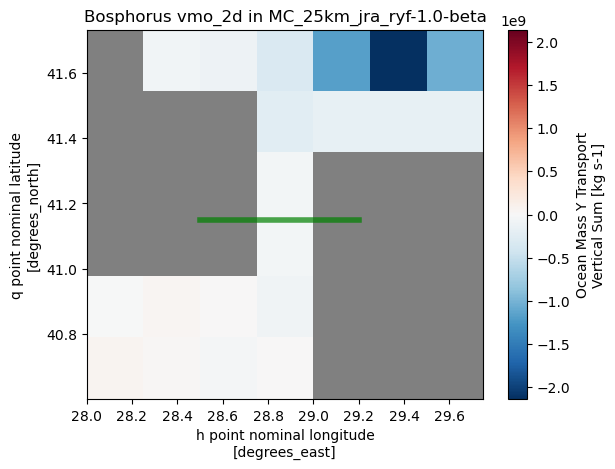

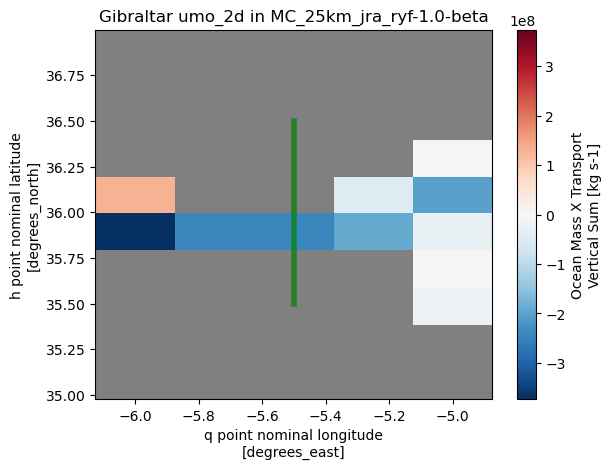

In [12]:
# plot maps of transect locations (just final time shown)
m = 0.5 # margin (degrees)
for strait, (xmin, xmax, ymin, ymax) in straits['25km'].items():
    print(strait)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_facecolor('gray')  # gray land points
    if xmin == xmax:
        umo_2d.umo_2d.isel(time=-1).sel(xq=slice(xmin-m, xmax+m)).sel(yh=slice(ymin-m, ymax+m)).plot()
        plt.title(f"{strait} umo_2d in {om3exptname}")
    elif ymin == ymax:
        vmo_2d.vmo_2d.isel(time=-1).sel(xh=slice(xmin-m, xmax+m)).sel(yq=slice(ymin-m, ymax+m)).plot()
        plt.title(f"{strait} vmo_2d in {om3exptname}")
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    plt.plot([xmin, xmax], [ymin, ymax], color='green', linewidth=4, alpha=0.7)

Drake Passage
Lombok Strait
Ombai Strait
Timor Strait
Bering Strait
Denmark Strait
East Taiwan Channel
Florida Current
Bosphorus
Gibraltar


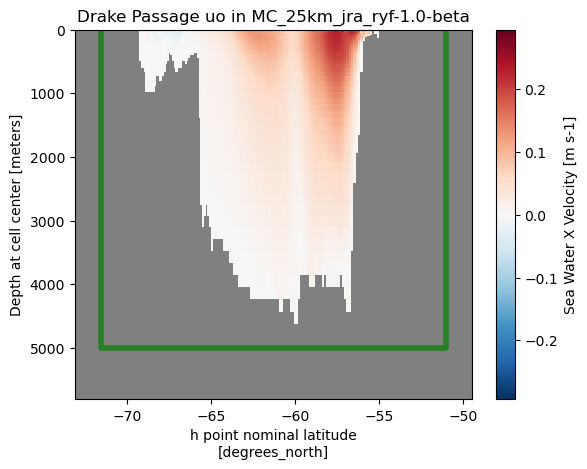

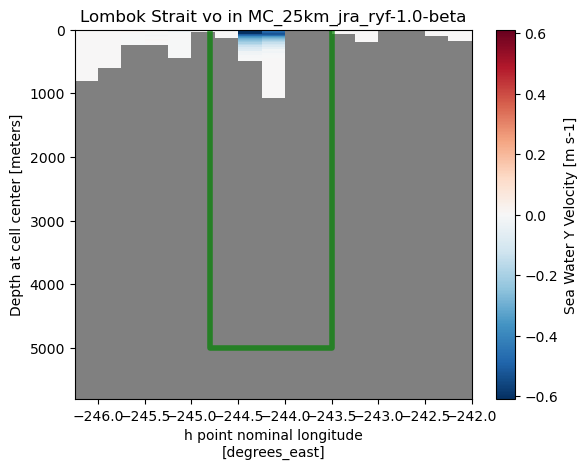

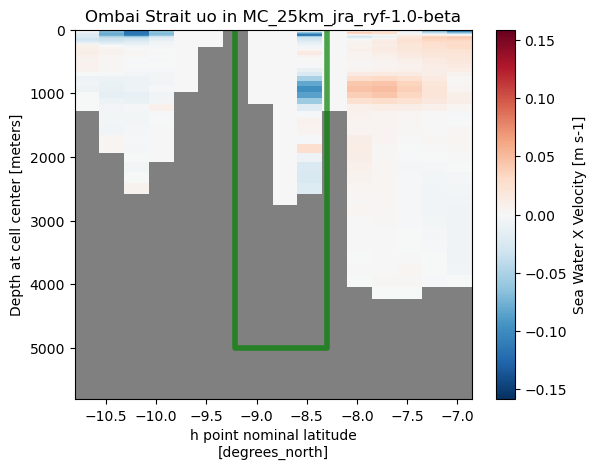

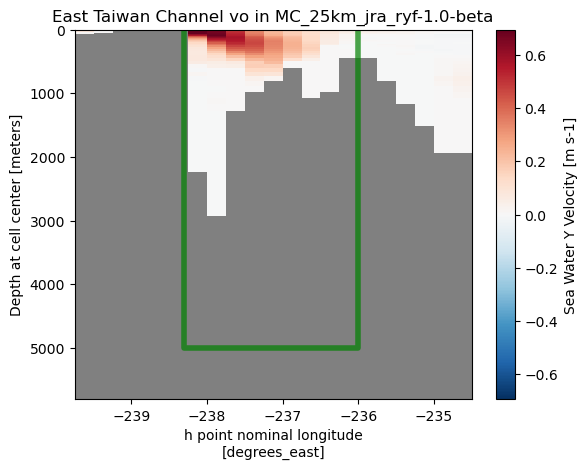

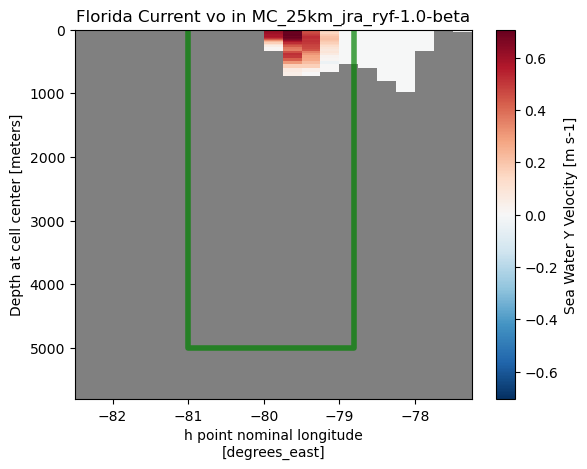

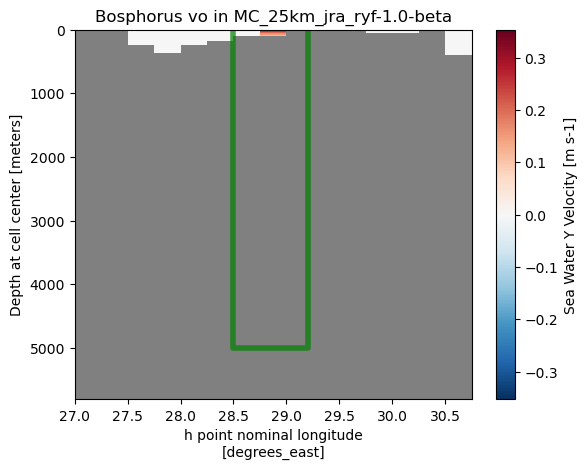

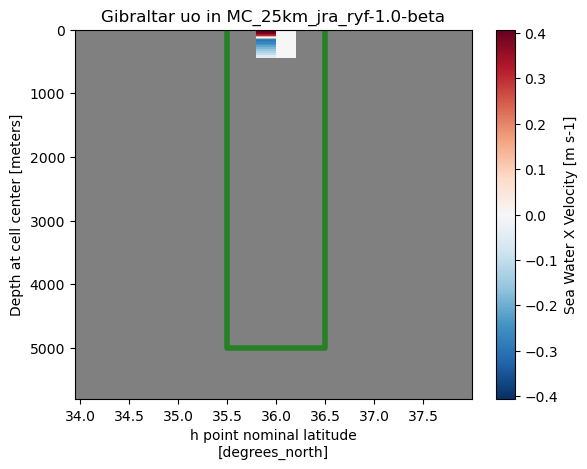

In [13]:
# plot vertical slices at transect locations (just final time shown)
m = 1.5 # margin (degrees)
for strait, (xmin, xmax, ymin, ymax) in straits['25km'].items():
    print(strait)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_facecolor('gray')  # gray land points
    if xmin == xmax:
        uo.uo.isel(time=-1).sel(xq=xmin, method='nearest').sel(yh=slice(ymin-m, ymax+m)).plot()
        plt.plot([ymin, ymin, ymax, ymax], [0, 5000, 5000, 0],
            color='green', linewidth=4, alpha=0.7)
        plt.title(f"{strait} uo in {om3exptname}")
    elif ymin == ymax:
        vo.vo.isel(time=-1).sel(xh=slice(xmin-m, xmax+m)).sel(yq=ymin, method='nearest').plot()
        plt.plot([xmin, xmin, xmax, xmax], [0, 5000, 5000, 0],
            color='green', linewidth=4, alpha=0.7)
        plt.title(f"{strait} vo in {om3exptname}")
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    plt.gca().invert_yaxis()

Drake Passage 168.20638 Sv Eastward
Lombok Strait -5.7412934 Sv Northward
Ombai Strait -1.4170073 Sv Eastward
Timor Strait -1.4763108 Sv Eastward
Bering Strait 0.9857392 Sv Northward
Denmark Strait -4.1687565 Sv Northward
East Taiwan Channel 28.162378 Sv Northward
Florida Current 18.658009 Sv Northward
Bosphorus -0.006339613 Sv Northward
Gibraltar 0.031861555 Sv Eastward


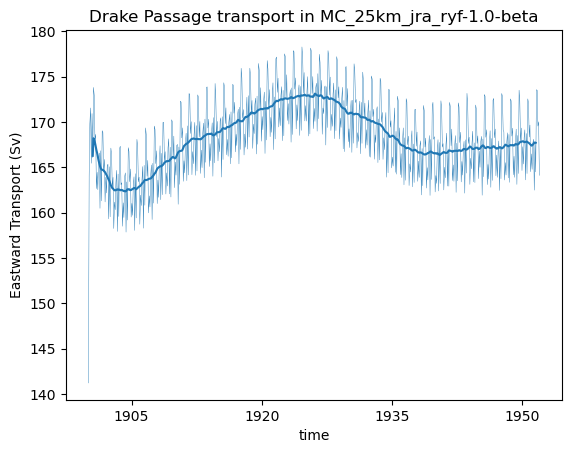

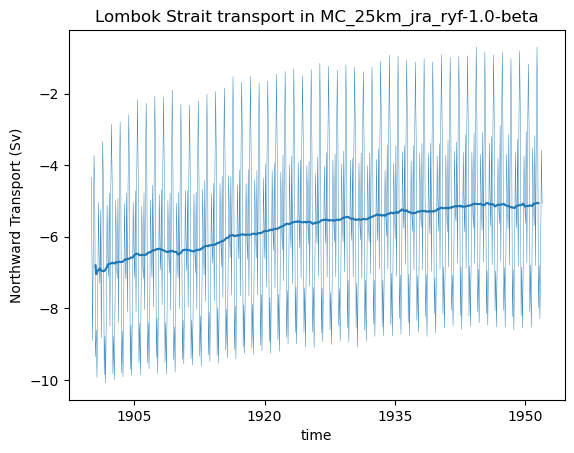

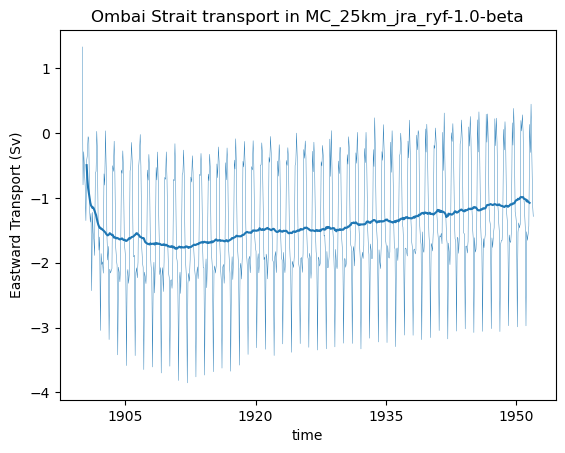

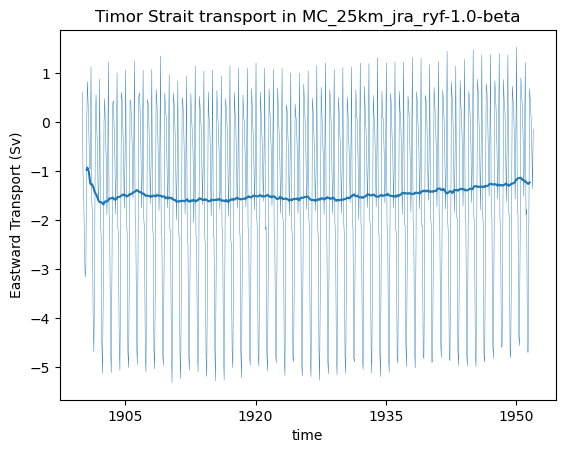

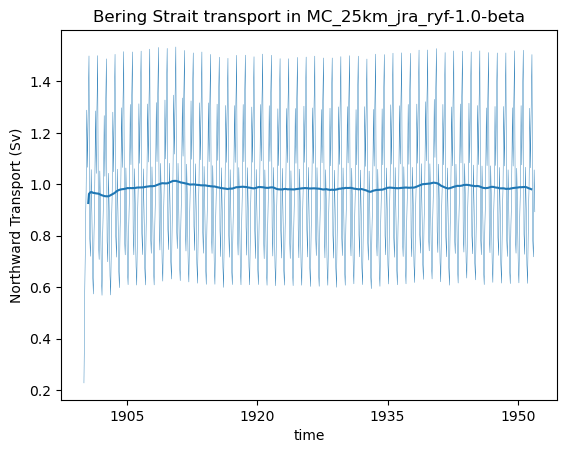

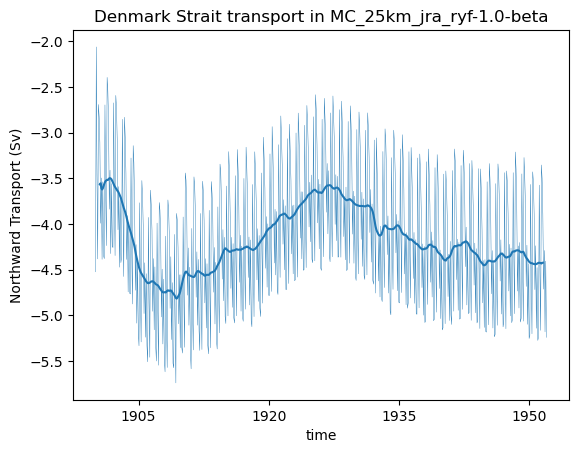

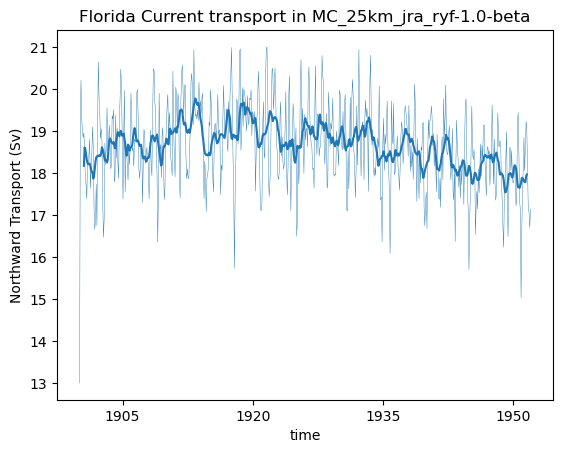

In [14]:
# plot mass transport timeseries (Sv)
for strait, (xmin, xmax, ymin, ymax) in straits['25km'].items():
    if xmin == xmax:
        trans = umo_2d.umo_2d.sel(xq=xmin, method='nearest').sel(yh=slice(ymin, ymax)).sum('yh')
        direction = 'Eastward'
    elif ymin == ymax:
        trans = vmo_2d.vmo_2d.sel(xh=slice(xmin, xmax)).sel(yq=ymin, method='nearest').sum('xh')
        direction = 'Northward'
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    trans = trans/1e6/1035  # convert to Sv, RHO_0 = 1035.0
    plt.figure()
    trans.plot(linewidth=0.3)
    trans.rolling(time=12, center=True).mean().plot(linewidth=1.5, color=plt.gca().lines[-1].get_color())
    plt.title(f"{strait} transport in {om3exptname}")
    plt.ylabel(f'{direction} Transport (Sv)')
    print(strait, trans.mean('time').values, 'Sv', direction)

## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [15]:
catalog = intake.cat.access_nri

In [16]:
om2exptname = '025deg_jra55_ryf9091_gadi'

In [17]:
var = catalog[om2exptname].search(variable='tx_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans_int_z = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [18]:
var = catalog[om2exptname].search(variable='ty_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
ty_trans_int_z = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [19]:
var = catalog[om2exptname].search(variable='tx_trans',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [20]:
var = catalog[om2exptname].search(variable='ty_trans',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
ty_trans = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Drake Passage
Lombok Strait
Ombai Strait
Timor Strait
Bering Strait
Denmark Strait
East Taiwan Channel
Florida Current
Bosphorus
Gibraltar


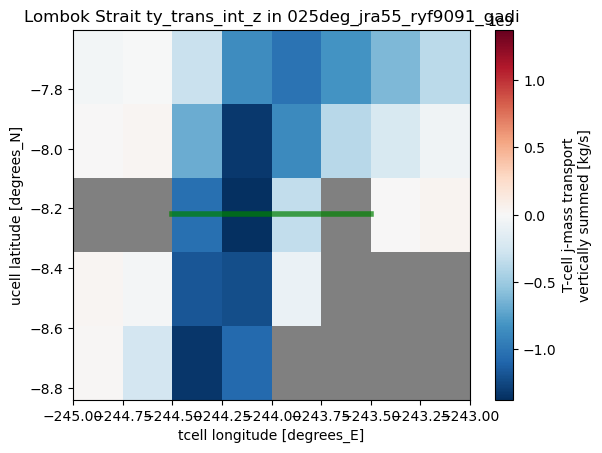

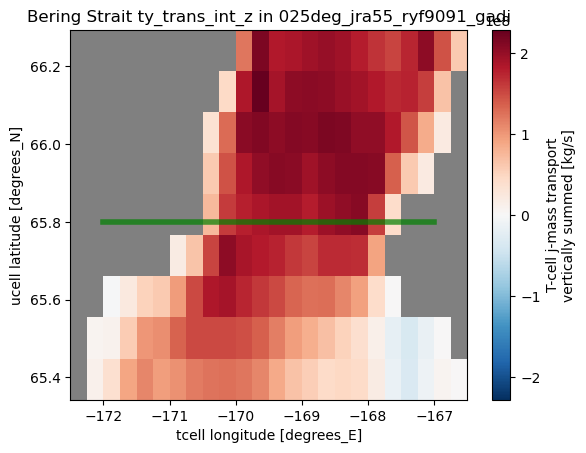

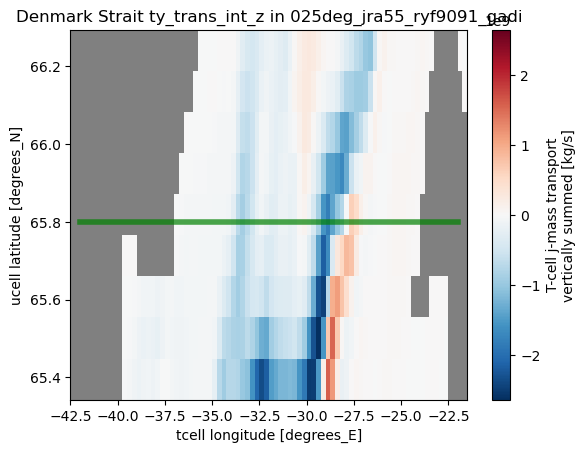

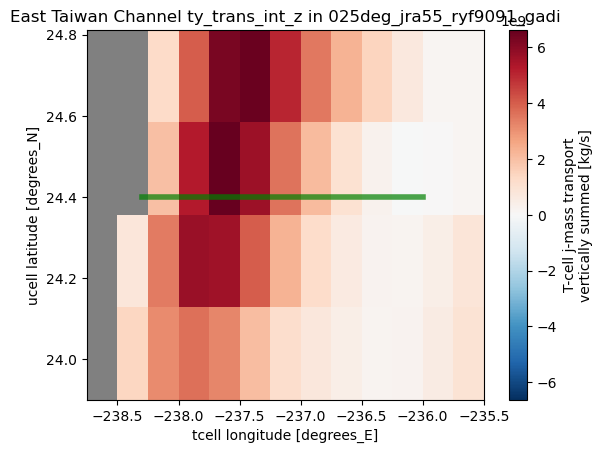

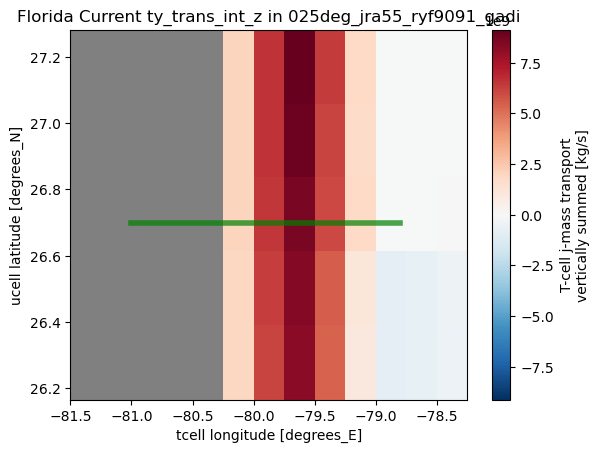

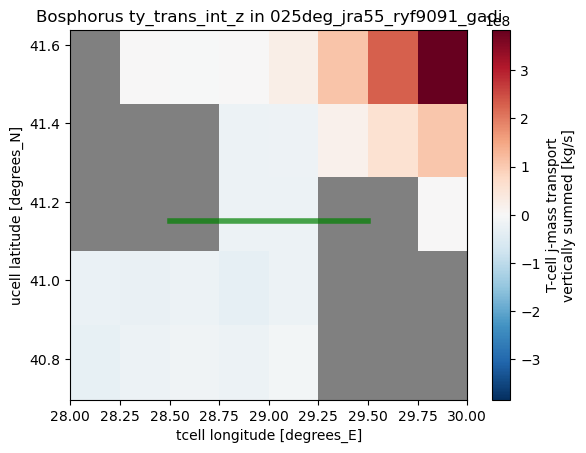

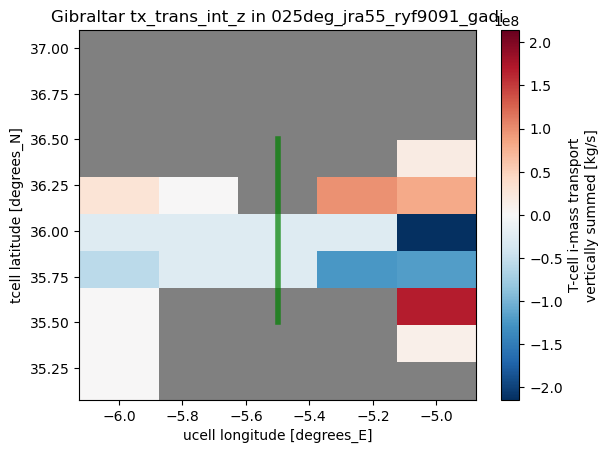

In [21]:
# plot maps of transect locations (just final time shown)
m = 0.5 # margin (degrees)
for strait, (xmin, xmax, ymin, ymax) in om2straits['025deg'].items():
    print(strait)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_facecolor('gray')  # gray land points
    if xmin == xmax:
        tx_trans_int_z.tx_trans_int_z.isel(time=-1).sel(xu_ocean=slice(xmin-m, xmax+m)).sel(yt_ocean=slice(ymin-m, ymax+m)).plot()
        plt.title(f"{strait} tx_trans_int_z in {om2exptname}")
    elif ymin == ymax:
        ty_trans_int_z.ty_trans_int_z.isel(time=-1).sel(xt_ocean=slice(xmin-m, xmax+m)).sel(yu_ocean=slice(ymin-m, ymax+m)).plot()
        plt.title(f"{strait} ty_trans_int_z in {om2exptname}")
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    plt.plot([xmin, xmax], [ymin, ymax], color='green', linewidth=4, alpha=0.7)

Drake Passage
Lombok Strait
Ombai Strait
Timor Strait
Bering Strait
Denmark Strait
East Taiwan Channel
Florida Current
Bosphorus
Gibraltar


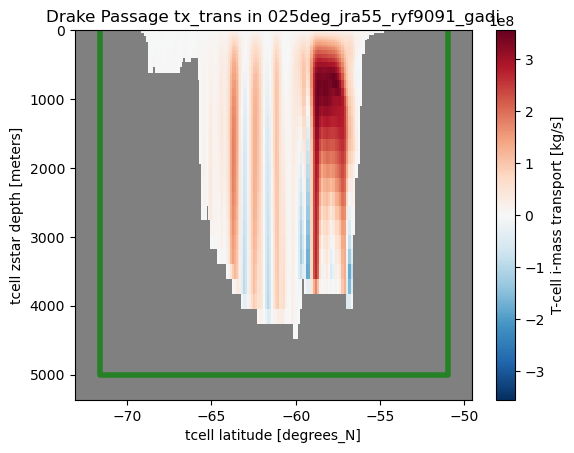

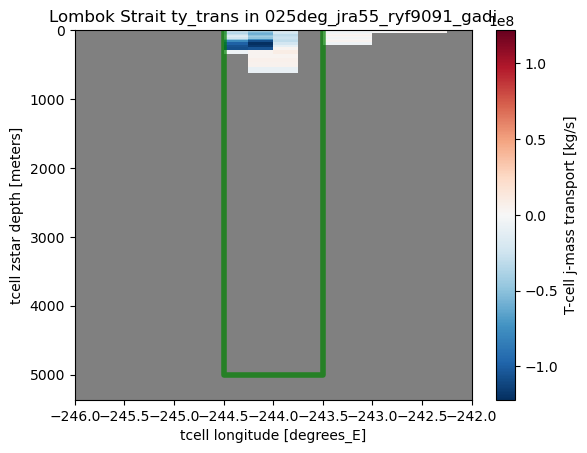

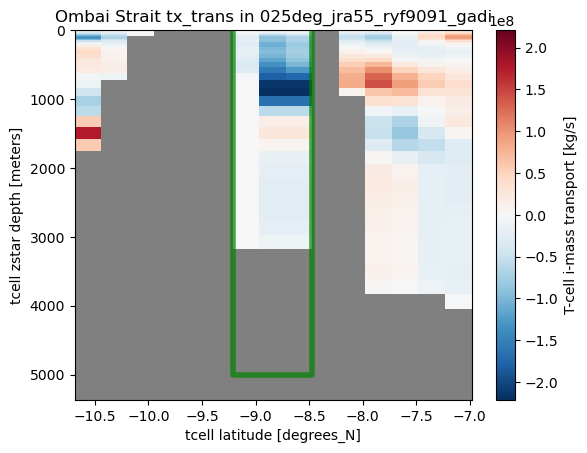

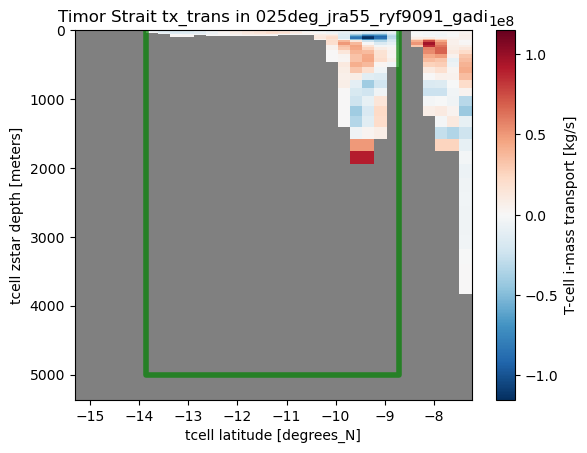

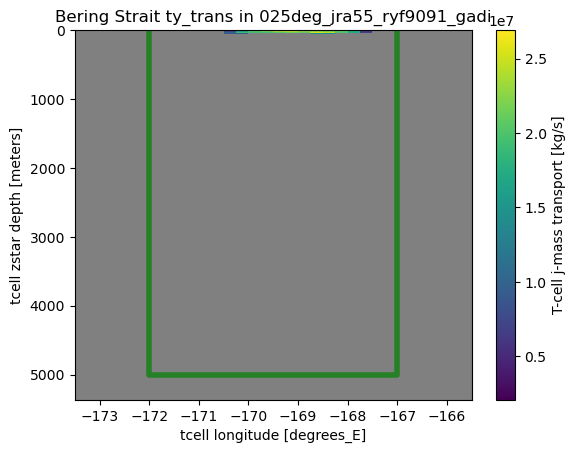

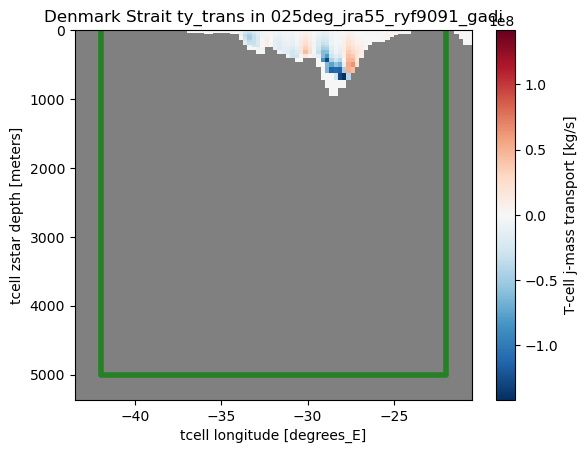

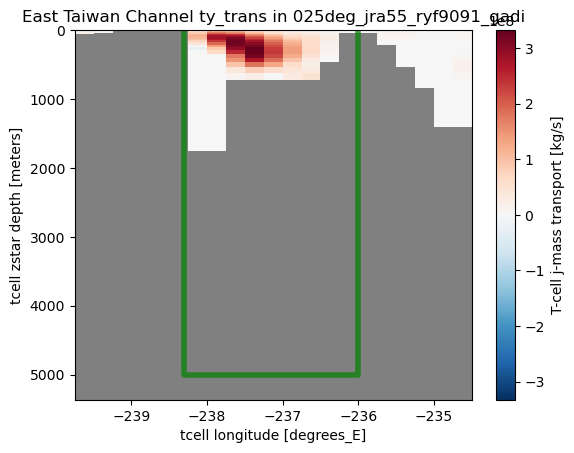

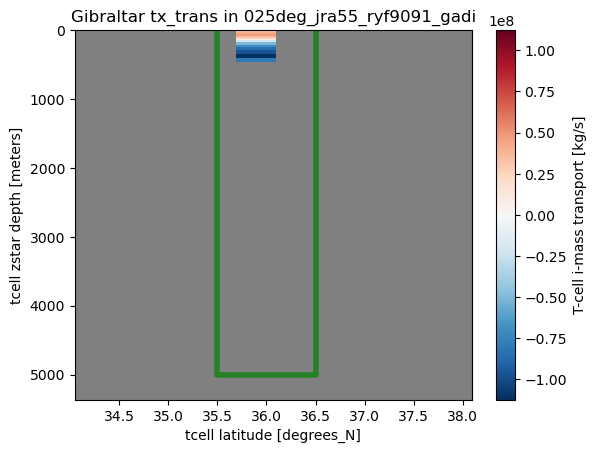

In [22]:
# plot vertical slices at transect locations (just final time shown)
m = 1.5 # margin (degrees)
for strait, (xmin, xmax, ymin, ymax) in om2straits['025deg'].items():
    print(strait)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_facecolor('gray')  # gray land points
    if xmin == xmax:
        tx_trans.tx_trans.isel(time=-1).sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin-m, ymax+m)).plot()
        plt.plot([ymin, ymin, ymax, ymax], [0, 5000, 5000, 0],
            color='green', linewidth=4, alpha=0.7)
        plt.title(f"{strait} tx_trans in {om2exptname}")
    elif ymin == ymax:
        ty_trans.ty_trans.isel(time=-1).sel(xt_ocean=slice(xmin-m, xmax+m)).sel(yu_ocean=ymin, method='nearest').plot()
        plt.plot([xmin, xmin, xmax, xmax], [0, 5000, 5000, 0],
            color='green', linewidth=4, alpha=0.7)
        plt.title(f"{strait} ty_trans in {om2exptname}")
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    plt.gca().invert_yaxis()
    # break

Drake Passage 139.7554 Sv Eastward
Lombok Strait -3.9971282 Sv Northward
Ombai Strait -3.1384118 Sv Eastward
Timor Strait -4.587683 Sv Eastward
Bering Strait 1.5223278 Sv Northward
Denmark Strait -13.592937 Sv Northward
East Taiwan Channel 30.428692 Sv Northward
Florida Current 22.640629 Sv Northward
Bosphorus -0.0061896793 Sv Northward
Gibraltar 0.032252245 Sv Eastward


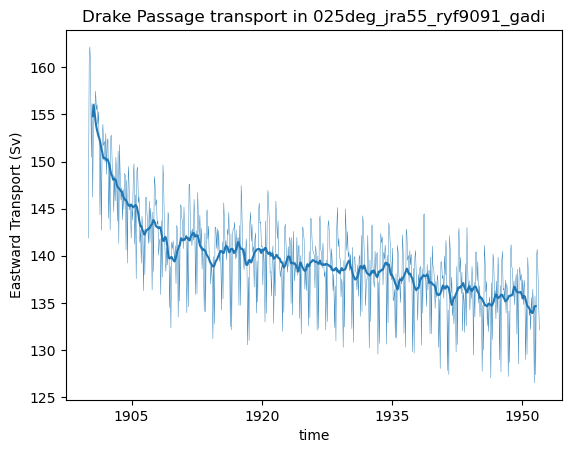

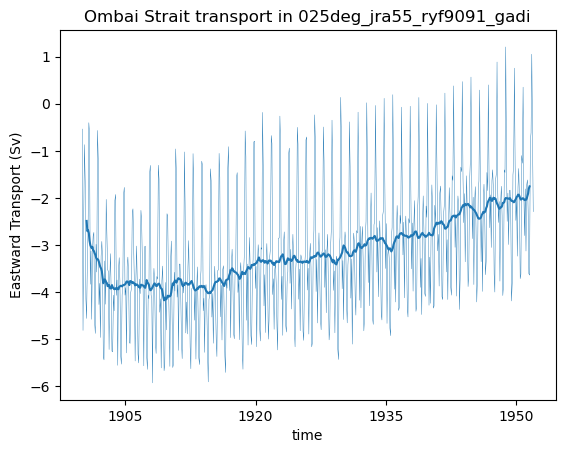

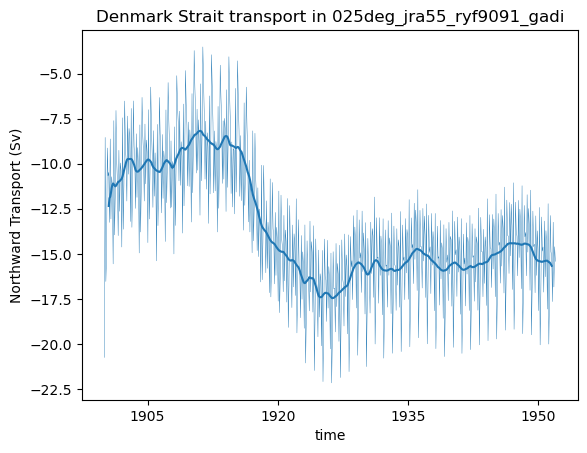

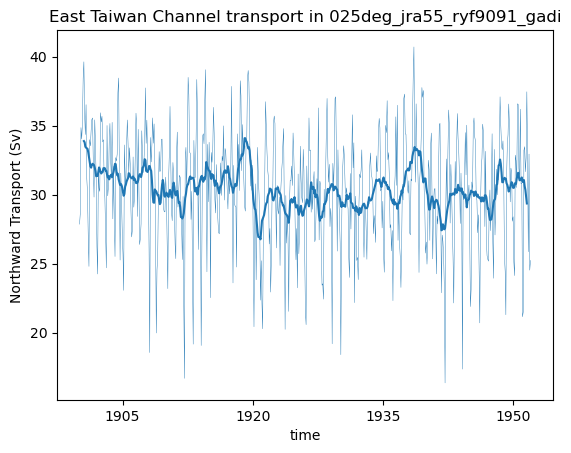

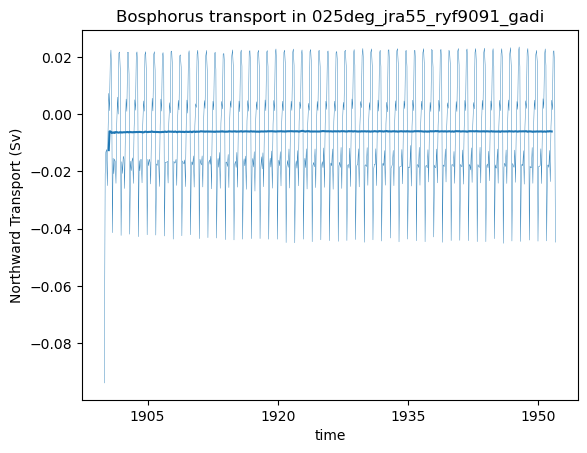

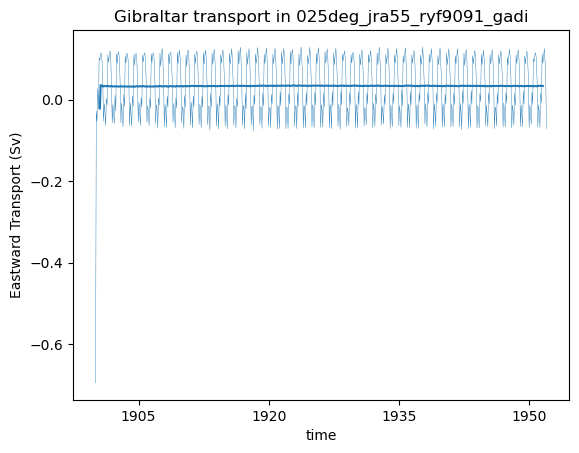

In [23]:
# plot mass transport timeseries (Sv)
for strait, (xmin, xmax, ymin, ymax) in om2straits['025deg'].items():
    if xmin == xmax:
        trans = tx_trans_int_z.tx_trans_int_z.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')
        direction = 'Eastward'
    elif ymin == ymax:
        trans = ty_trans_int_z.ty_trans_int_z.sel(xt_ocean=slice(xmin, xmax)).sel(yu_ocean=ymin, method='nearest').sum('xt_ocean')
        direction = 'Northward'
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    trans = trans/1e6/1035  # convert to Sv, rho0 = 1035.0
    trans = trans.sel(time=timeslice)
    plt.figure()
    trans.plot(linewidth=0.3)
    trans.rolling(time=12, center=True).mean().plot(linewidth=1.5, color=plt.gca().lines[-1].get_color())
    plt.title(f"{strait} transport in {om2exptname}")
    plt.ylabel(f'{direction} Transport (Sv)')
    print(strait, trans.mean('time').values, 'Sv', direction)

### Plot OM3 and OM2

Drake Passage OM3 = 168.20638 ; OM2 = 139.7554 Sv Eastward
Lombok Strait OM3 = -5.7412934 ; OM2 = -3.9971282 Sv Northward
Ombai Strait OM3 = -1.4170073 ; OM2 = -3.1384118 Sv Eastward
Timor Strait OM3 = -1.4763108 ; OM2 = -4.587683 Sv Eastward
Bering Strait OM3 = 0.9857392 ; OM2 = 1.5223278 Sv Northward
Denmark Strait OM3 = -4.1687565 ; OM2 = -13.592937 Sv Northward
East Taiwan Channel OM3 = 28.162378 ; OM2 = 30.428692 Sv Northward
Florida Current OM3 = 18.658009 ; OM2 = 22.640629 Sv Northward
Bosphorus OM3 = -0.006339613 ; OM2 = -0.0061896793 Sv Northward
Gibraltar OM3 = 0.031861555 ; OM2 = 0.032252245 Sv Eastward


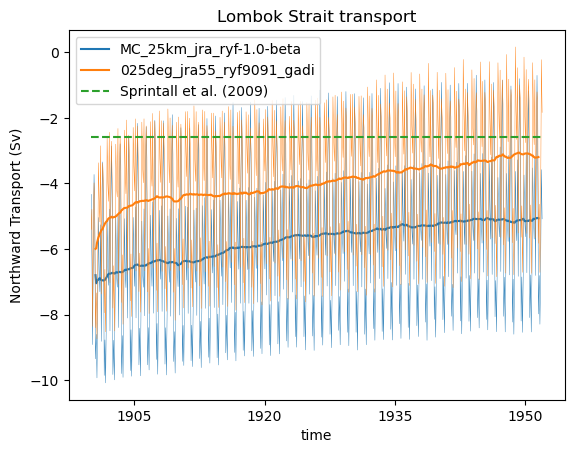

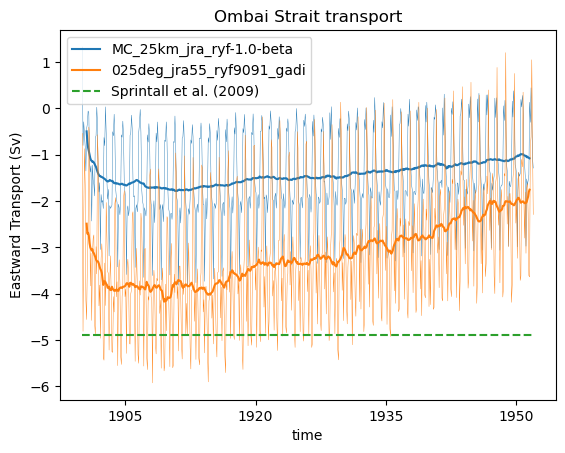

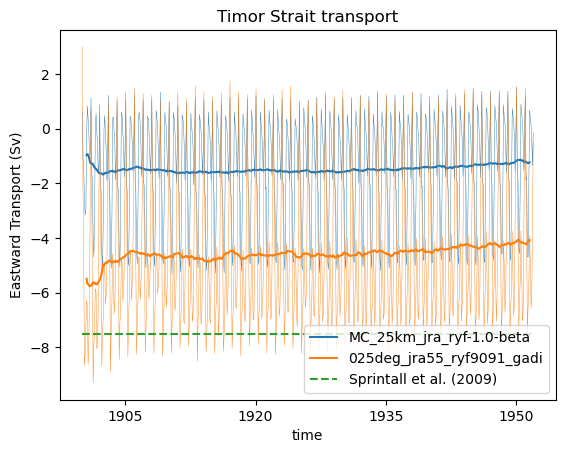

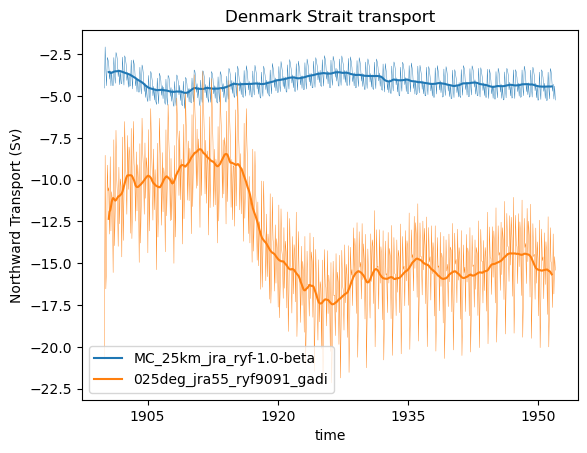

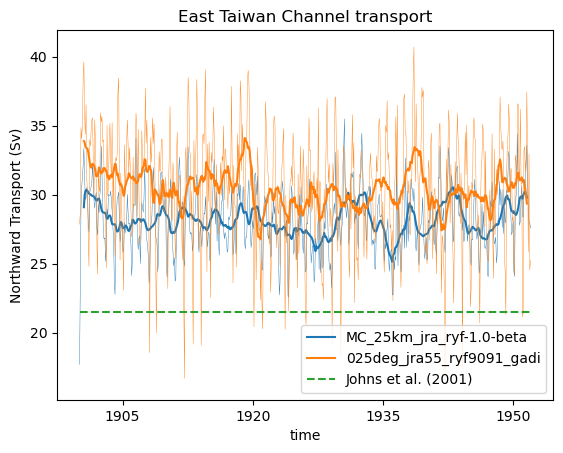

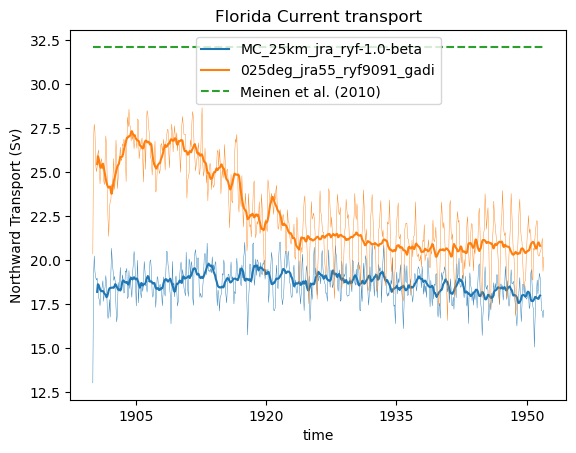

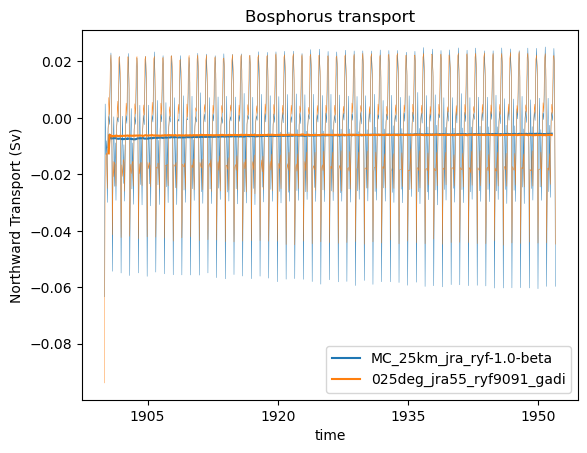

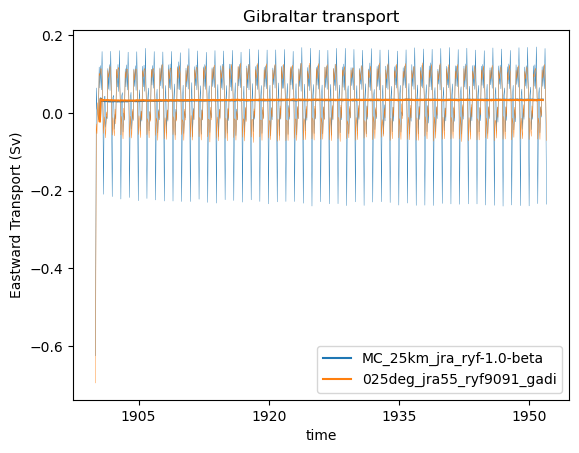

In [24]:
# plot mass transport timeseries (Sv)
for strait, (xmin, xmax, ymin, ymax) in straits['25km'].items():
    plt.figure()

    if xmin == xmax:
        trans = umo_2d.umo_2d.sel(xq=xmin, method='nearest').sel(yh=slice(ymin, ymax)).sum('yh')
        direction = 'Eastward'
    elif ymin == ymax:
        trans = vmo_2d.vmo_2d.sel(xh=slice(xmin, xmax)).sel(yq=ymin, method='nearest').sum('xh')
        direction = 'Northward'
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    trans = trans/1e6/1035  # convert to Sv, RHO_0 = 1035.0
    trans.plot(linewidth=0.3)
    trans.rolling(time=12, center=True).mean().plot(label=om3exptname, linewidth=1.5, color=plt.gca().lines[-1].get_color())
    transmean = trans.mean('time').values

    if strait in om2straits['025deg']:
        (xmin, xmax, ymin, ymax) = om2straits['025deg'][strait]
        if xmin == xmax:
            trans = tx_trans_int_z.tx_trans_int_z.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')
        elif ymin == ymax:
            trans = ty_trans_int_z.ty_trans_int_z.sel(xt_ocean=slice(xmin, xmax)).sel(yu_ocean=ymin, method='nearest').sum('xt_ocean')
        else:
            raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
        trans = trans/1e6/1035  # convert to Sv, rho0 = 1035.0
        trans = trans.sel(time=timeslice)
        trans.plot(linewidth=0.3)
        trans.rolling(time=12, center=True).mean().plot(label=om2exptname, linewidth=1.5, color=plt.gca().lines[-1].get_color())
        om2transmean = trans.mean('time').values
        print(strait, 'OM3 =', transmean, '; OM2 =', om2transmean, 'Sv', direction)
    else:
        print(strait, 'OM3 =', transmean, 'Sv', direction)

    if strait in obs:
        for ref, val in obs[strait].items():
            plt.plot([timeslice.start, timeslice.stop], [val, val], '--', label=ref)

    plt.title(f"{strait} transport")
    plt.ylabel(f'{direction} Transport (Sv)')
    plt.legend()

In [25]:
client.close()